In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import torch
import requests
import os
from sklearn.preprocessing import MinMaxScaler



**Open source database** : "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/refs/heads/main/ETT-small/ETTh1.csv"

## 📊 ETTh1 Dataset Description

The **ETTh1 (Electricity Transformer Temperature dataset, Hourly resolution, part 1)** is a time-series dataset used for forecasting power system load and transformer oil temperature.

### 📌 **Variables:**
- **`date`** : Timestamp indicating the moment of measurement (format: YYYY-MM-DD HH:mm:ss).
- **`HUFL`** : High Use Frequency Load – High-frequency load usage.
- **`HULL`** : High Use Low Load – Low load under high usage conditions.
- **`MUFL`** : Medium Use Frequency Load – Medium-frequency load usage.
- **`MULL`** : Medium Use Low Load – Low load under medium usage conditions.
- **`LUFL`** : Low Use Frequency Load – Low-frequency load usage.
- **`LULL`** : Low Use Low Load – Low load under low usage conditions.
- **`OT`** (**Target Variable**) : Oil Temperature – Transformer oil temperature, the variable to be predicted.

### 🔍 **Objective:**
The dataset is commonly used for **time-series forecasting** tasks, aiming to predict **oil temperature (`OT`)** based on energy load features and temporal trends.

🚀 This dataset is widely applied in **deep learning models like LSTMs, Transformers, and machine learning algorithms like XGBoost** for energy management and predictive maintenance.


In [ ]:
df = pd.read_csv('C:/Users/ugo11/OneDrive/Bureau/Data/FAN/ETTh1.csv')

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print("df before scaling")
display(df)

scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

print("df scaled")
display(df_scaled)

df before scaling


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...
2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000


df scaled


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,0.615599,0.454943,0.628980,0.467510,0.556576,0.613765,0.691018
2016-07-01 01:00:00,0.612708,0.459449,0.626458,0.464878,0.550279,0.620783,0.636233
2016-07-01 02:00:00,0.601143,0.436920,0.621438,0.459689,0.512595,0.586144,0.636233
2016-07-01 03:00:00,0.599698,0.450437,0.621438,0.462320,0.515693,0.599955,0.581468
2016-07-01 04:00:00,0.605480,0.450437,0.626458,0.467510,0.521990,0.599955,0.519656
...,...,...,...,...,...,...,...
2018-06-26 15:00:00,0.453765,0.558574,0.458955,0.589577,0.481107,0.655196,0.299159
2018-06-26 16:00:00,0.371392,0.608137,0.376064,0.599956,0.487404,0.689608,0.301955
2018-06-26 17:00:00,0.550572,0.576597,0.572038,0.587018,0.506298,0.655196,0.286521


In [81]:
def create_sequences(features, target, input_length, horizon):
    X, y = [], []

    for i in range(len(features) - input_length - horizon + 1):
        X_seq = features[i: i + input_length]
        y_seq = target[i + input_length: i + input_length + horizon]
        y.append(y_seq)
        X.append(X_seq)

    return np.array(X), np.array(y)

input_length = 24
horizon = 24
target_col = "OT"

target_data = df_scaled[target_col].values
feature_data  = df_scaled.values

X, y = create_sequences(feature_data, target_data, input_length, horizon)

print(f"Shape of X {X.shape}")
print(f"Shape of y {y.shape}")


Shape of X (17373, 24, 7)
Shape of y (17373, 24)


In [102]:
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TimeSeriesDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))

train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Size of training Dataset: {len(train_dataset)}")
print(f"Size of testing Dataset: {len(test_dataset)}")


Size of training Dataset: 13898
Size of testing Dataset: 3475


**MLP** architecture vs **FAN** architecture

In [100]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = self.Linear(input_dim, hidden_dim)
        self.fc2 = self.Linear(hidden_dim, hidden_dim)
        self.fc3 = self.Linear(hidden_dim, output_dim)

        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x
    


17373

In [51]:


class FANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, p_ratio=0.25, activation='gelu', use_p_bias=True):
        super(FANLayer, self).__init__()
        
        assert 0 < p_ratio < 0.5, "p_ratio doit être entre 0 et 0.5"
        self.p_ratio = p_ratio
        p_output_dim = int(output_dim * self.p_ratio)
        g_output_dim = output_dim - (p_output_dim * 2)

        self.input_linear_p = nn.Linear(input_dim, p_output_dim, bias=use_p_bias)
        self.input_linear_g = nn.Linear(input_dim, g_output_dim)

        if isinstance(activation, str):
            self.activation = getattr(F, activation)
        else:
            self.activation = activation if activation else lambda x: x

    def forward(self, src):
        g = self.activation(self.input_linear_g(src))
        p = self.input_linear_p(src)
        output = torch.cat((torch.cos(p), torch.sin(p), g), dim=-1)
        return output
    



# Modèle avec FANLayer
class FAN_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FAN_MLP, self).__init__()
        self.fan = FANLayer(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.fan(x)
        x = self.activation(self.fc(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x
    


In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Modification de la fonction d'entraînement pour stocker la loss
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    model.train()
    
    train_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            outputs = outputs[:, -1, :]  # Prend uniquement la dernière valeur temporelle


            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    
    return train_losses

# Modification de la fonction d'évaluation pour stocker la loss
def evaluate_model(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            outputs = outputs[:, -1, :]  # Prend uniquement la dernière valeur temporelle

            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.6f}")
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    return avg_loss, all_preds, all_targets


In [49]:
# Définition des dimensions des entrées et des sorties
input_dim = X_tensor.shape[2]  # Nombre de features (variables d'entrée)
hidden_dim = 128  # Nombre de neurones dans la couche cachée
output_dim = y_tensor.shape[1]  # Nombre de sorties (variable cible)
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [53]:
# Initialisation des modèles
mlp_model = MLP(input_dim, hidden_dim, output_dim).to(device)
fan_mlp_model = FAN_MLP(input_dim, hidden_dim, output_dim).to(device)


# Définition des optimisateurs
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
fan_mlp_optimizer = optim.Adam(fan_mlp_model.parameters(), lr=0.001)

# Entraînement et évaluation du MLP classique
print("\n🔹 Entraînement du MLP classique")
mlp_train_losses = train_model(mlp_model, train_loader, nn.MSELoss(), mlp_optimizer, device, epochs)
mlp_test_loss, mlp_preds, mlp_targets = evaluate_model(mlp_model, test_loader, nn.MSELoss(), device)

# Entraînement et évaluation du FAN MLP
print("\n🔹 Entraînement du FAN MLP")
fan_mlp_train_losses = train_model(fan_mlp_model, train_loader, nn.MSELoss(), fan_mlp_optimizer, device, epochs)
fan_mlp_test_loss, fan_preds, fan_targets = evaluate_model(fan_mlp_model, test_loader, nn.MSELoss(), device)


#0.02725
#0.02751


🔹 Entraînement du MLP classique
Epoch [1/10], Loss: 0.010587
Epoch [2/10], Loss: 0.002699
Epoch [3/10], Loss: 0.002725
Epoch [4/10], Loss: 0.002685
Epoch [5/10], Loss: 0.002699
Epoch [6/10], Loss: 0.002716
Epoch [7/10], Loss: 0.002688
Epoch [8/10], Loss: 0.002684
Epoch [9/10], Loss: 0.002692
Epoch [10/10], Loss: 0.002663
Test Loss: 0.002706

🔹 Entraînement du FAN MLP
Epoch [1/10], Loss: 0.009377
Epoch [2/10], Loss: 0.002836
Epoch [3/10], Loss: 0.002830
Epoch [4/10], Loss: 0.002801
Epoch [5/10], Loss: 0.002792
Epoch [6/10], Loss: 0.002780
Epoch [7/10], Loss: 0.002771
Epoch [8/10], Loss: 0.002762
Epoch [9/10], Loss: 0.002787
Epoch [10/10], Loss: 0.002765
Test Loss: 0.002622


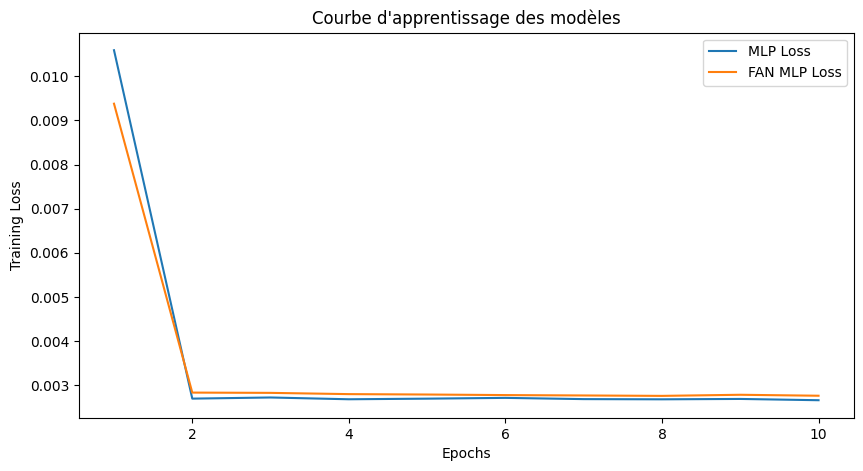

In [54]:
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), mlp_train_losses, label="MLP Loss")
plt.plot(range(1, epochs+1), fan_mlp_train_losses, label="FAN MLP Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Courbe d'apprentissage des modèles")
plt.legend()
plt.show()


In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcul des métriques pour le MLP
mlp_mae = mean_absolute_error(mlp_targets, mlp_preds)
mlp_rmse = np.sqrt(mean_squared_error(mlp_targets, mlp_preds))

# Calcul des métriques pour le FAN MLP
fan_mae = mean_absolute_error(fan_targets, fan_preds)
fan_rmse = np.sqrt(mean_squared_error(fan_targets, fan_preds))

# Affichage des résultats
print("\n📊 Comparaison des performances sur le test set")
print(f"MLP - MSE: {mlp_test_loss:.6f}, MAE: {mlp_mae:.6f}, RMSE: {mlp_rmse:.6f}")
print(f"FAN MLP - MSE: {fan_mlp_test_loss:.6f}, MAE: {fan_mae:.6f}, RMSE: {fan_rmse:.6f}")



📊 Comparaison des performances sur le test set
MLP - MSE: 0.002706, MAE: 0.035104, RMSE: 0.052014
FAN MLP - MSE: 0.002622, MAE: 0.035578, RMSE: 0.051202


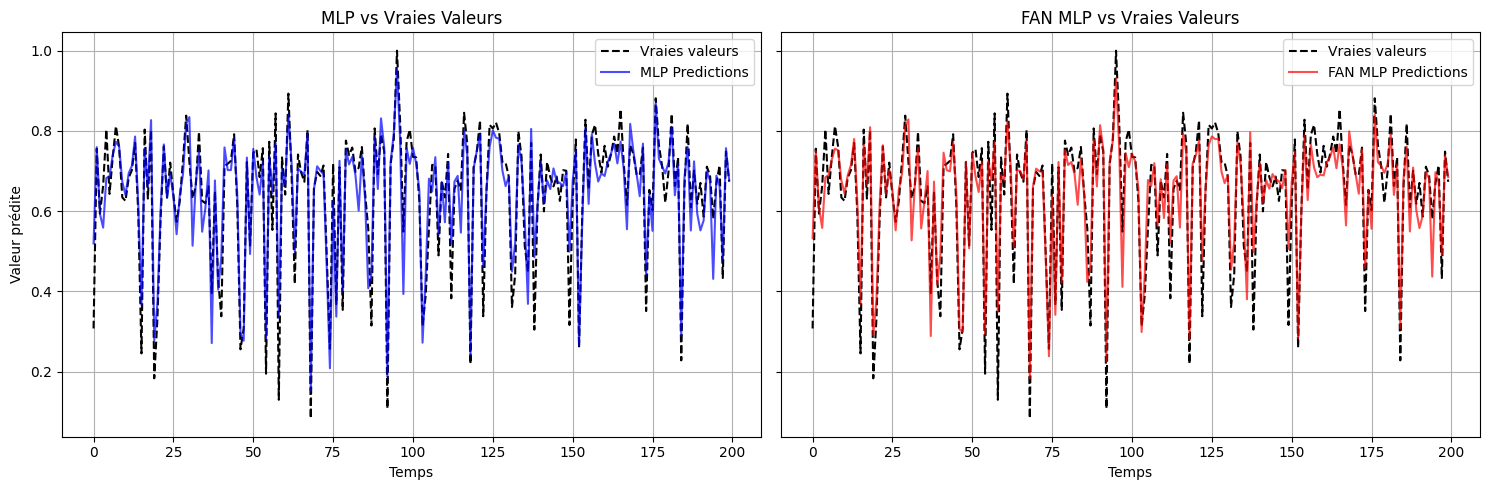

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Nombre de points à afficher (ex: 200 premiers)
plot_range = 200
variable_index = 0  # Choisir l'index de la variable cible (ex: 0 pour la première variable)

# Création de la figure avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)  # 1 ligne, 2 colonnes

# 🔹 Graphique 1 : Vraies valeurs vs MLP Predictions
axes[0].plot(fan_targets[:plot_range, variable_index], label="Vraies valeurs", color="black", linestyle="dashed")
axes[0].plot(mlp_preds[:plot_range, variable_index], label="MLP Predictions", color="blue", alpha=0.7)
axes[0].set_title("MLP vs Vraies Valeurs")
axes[0].set_xlabel("Temps")
axes[0].set_ylabel("Valeur prédite")
axes[0].legend()
axes[0].grid(True)

# 🔹 Graphique 2 : Vraies valeurs vs FAN MLP Predictions
axes[1].plot(fan_targets[:plot_range, variable_index], label="Vraies valeurs", color="black", linestyle="dashed")
axes[1].plot(fan_preds[:plot_range, variable_index], label="FAN MLP Predictions", color="red", alpha=0.7)
axes[1].set_title("FAN MLP vs Vraies Valeurs")
axes[1].set_xlabel("Temps")
axes[1].legend()
axes[1].grid(True)

# Ajustement des espaces entre les graphiques
plt.tight_layout()

# Affichage
plt.show()
